# Library

In [91]:
#Library to dataset
import os
import numpy as np
import pandas as pd

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import EfficientNetV2S

# Others
import shutil
import random
import librosa

# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from mlxtend.plotting import plot_confusion_matrix

In [2]:
!nvidia-smi

Sun Jun 18 10:58:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:D5:00.0 Off |                    0 |
|  0%   25C    P8    20W / 300W |      0MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Audio Dataset

In [3]:
# Audio processing parameters
sample_rate = 16000  # Sample rate of the audio files
n_fft = 400  # Number of FFT points for spectrogram
hop_length = 160  # Hop length for spectrogram
duration = 15  # Desired duration of each audio file in seconds

In [4]:
# Define the classes/categories for audio classification
classes = ['Yes', 'No']

In [5]:
# Set the model parameters
batch_size = 4
num_epochs = 100

In [6]:
# Function to process audio file
def process_audio(file_path):
    # Load the audio file
    audio, _ = librosa.load(file_path, sr=16000, duration=15)

    # Compute the spectrogram
    spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length)


    # Convert to decibel scale
    spec_db = librosa.power_to_db(spec, ref=np.max)

    return spec_db

In [7]:
# Load the train data
train_data = []
train_labels = []

for class_label, class_name in enumerate(classes):
    class_folder = os.path.join("Dataset/Train", class_name)
    for filename in os.listdir(class_folder):
        if filename.endswith('.mp3'):
            file_path = os.path.join(class_folder, filename)
            # Load and process the audio file
            train_data.append(process_audio(file_path))
            train_labels.append(class_label)

# Convert the train data and labels to NumPy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [8]:
# Load the test data
test_data = []
test_labels = []

for class_label, class_name in enumerate(classes):
    class_folder = os.path.join("Dataset/Valid", class_name)
    for filename in os.listdir(class_folder):
        if filename.endswith('.mp3'):
            file_path = os.path.join(class_folder, filename)
            # Load and process the audio file
            test_data.append(process_audio(file_path))
            test_labels.append(class_label)

# Convert the test data and labels to NumPy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [9]:
# get the shape of the training and testing datasets
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Valid data shape:", test_data.shape)
print("Valid labels shape:", test_labels.shape)

Train data shape: (2852, 128, 1501)
Train labels shape: (2852,)
Valid data shape: (804, 128, 1501)
Valid labels shape: (804,)


In [10]:
# Check label distribution
unique_elements, counts_elements = np.unique(train_labels, return_counts=True)
print("Label distribution:", dict(zip(unique_elements, counts_elements)))

Label distribution: {0: 1728, 1: 1124}


In [11]:
# Ensure the target arrays have the correct shape
train_labels = np.expand_dims(train_labels, axis=1)
test_labels = np.expand_dims(test_labels, axis=1)

In [12]:
# Add channel dimension to the train data
train_data = np.expand_dims(train_data, axis=-1)
test_data = np.expand_dims(test_data, axis=-1)

# Modelling DIY

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="DIY.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [18]:
# Define Basic Model
DIY_Model  = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.InputLayer(input_shape=train_data.shape[1:]),
    # Convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    # Max pooling layer
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    # Convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # Max pooling layer
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    # Convolutional layer
    tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
    # Max pooling layer
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(128, activation='relu'),
    # Dropout layer
    tf.keras.layers.Dropout(0.2),
    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
DIY_Model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
DIY_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 1499, 32)     320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 750, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 748, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 374, 64)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 373, 128)      32896     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 187, 128)    

In [19]:
# Train the model
history = DIY_Model.fit(train_data, train_labels, validation_data=(test_data, test_labels), batch_size=batch_size, epochs=num_epochs, callbacks=callbacks)

Epoch 1/100
710/713 [============================>.] - ETA: 0s - loss: 3.8359 - accuracy: 0.6947
Epoch 1: val_accuracy did not improve from 0.55721
713/713 [==============================] - 13s 15ms/step - loss: 3.8228 - accuracy: 0.6939 - val_loss: 0.6914 - val_accuracy: 0.5373 - lr: 0.0010
Epoch 2/100
710/713 [============================>.] - ETA: 0s - loss: 0.6995 - accuracy: 0.6116
Epoch 2: val_accuracy did not improve from 0.55721
713/713 [==============================] - 10s 14ms/step - loss: 0.6994 - accuracy: 0.6115 - val_loss: 0.6987 - val_accuracy: 0.5373 - lr: 0.0010
Epoch 3/100
709/713 [============================>.] - ETA: 0s - loss: 0.6715 - accuracy: 0.6054
Epoch 3: val_accuracy did not improve from 0.55721
713/713 [==============================] - 10s 14ms/step - loss: 0.6713 - accuracy: 0.6059 - val_loss: 0.7083 - val_accuracy: 0.5373 - lr: 0.0010
Epoch 4/100
712/713 [============================>.] - ETA: 0s - loss: 0.6711 - accuracy: 0.6060
Epoch 4: val_accuracy

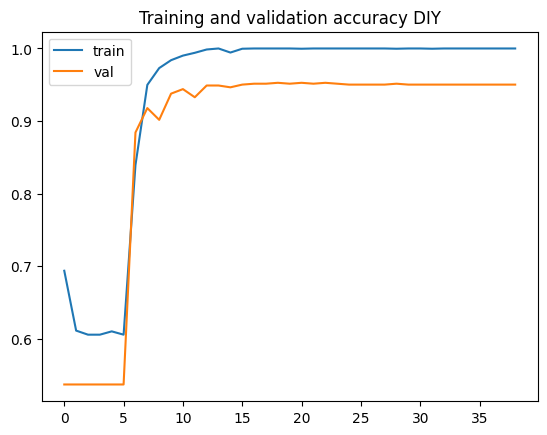

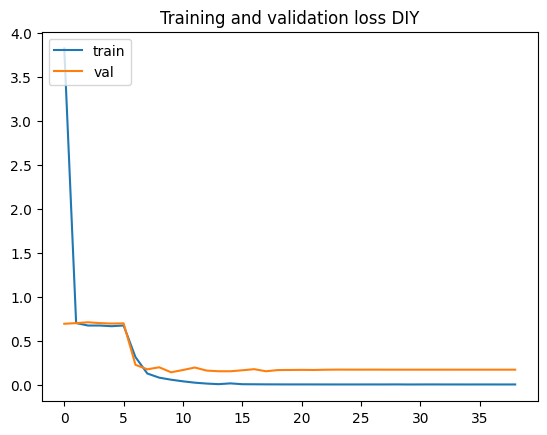

In [84]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy' ]
val_acc  = history.history['val_accuracy' ]
loss     = history.history['loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY')
plt.legend(['train', 'val'], loc='upper left')

In [24]:
# Evaluate the model
test_loss, test_acc = DIY_Model.evaluate(test_data, test_labels, verbose=2)
# Print out the model accuracy
print("Test accuracy:", test_acc)
# Print out the model loss
print("Test loss:", test_loss)

26/26 - 1s - loss: 0.1645 - accuracy: 0.9527 - 610ms/epoch - 23ms/step
Test accuracy: 0.9527363181114197
Test loss: 0.1645437777042389


# Modelling MobileNetV2

In [69]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="MobileNetV2.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [74]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights=None,input_shape=train_data.shape[1:]),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(1, activation='sigmoid') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 47, 1280)      2257408   
 ional)                                                          
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_11 (Dropout)        (None, 1280)              0         
                                                                 
 dense_22 (Dense)            (None, 256)               327936    
                                                                 
 dense_23 (Dense)            (None, 1)                 257       
                                                                 
Total params: 2,585,601
Trainable params: 2,551,489
N

In [75]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_data, train_labels, validation_data=(test_data, test_labels), batch_size=batch_size, epochs=num_epochs, callbacks=callbacks)

Epoch 1/100
713/713 [==============================] - ETA: 0s - loss: 0.8057 - accuracy: 0.7111
Epoch 1: val_accuracy improved from 0.46269 to 0.53731, saving model to MobileNetV2.h5
713/713 [==============================] - 53s 39ms/step - loss: 0.8057 - accuracy: 0.7111 - val_loss: 0.6917 - val_accuracy: 0.5373 - lr: 0.0010
Epoch 2/100
713/713 [==============================] - ETA: 0s - loss: 0.3286 - accuracy: 0.8654
Epoch 2: val_accuracy did not improve from 0.53731
713/713 [==============================] - 26s 36ms/step - loss: 0.3286 - accuracy: 0.8654 - val_loss: 0.6910 - val_accuracy: 0.5373 - lr: 0.0010
Epoch 3/100
713/713 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.8878
Epoch 3: val_accuracy did not improve from 0.53731
713/713 [==============================] - 26s 37ms/step - loss: 0.2682 - accuracy: 0.8878 - val_loss: 0.6905 - val_accuracy: 0.5373 - lr: 0.0010
Epoch 4/100
713/713 [==============================] - ETA: 0s - loss: 0.2326 - ac

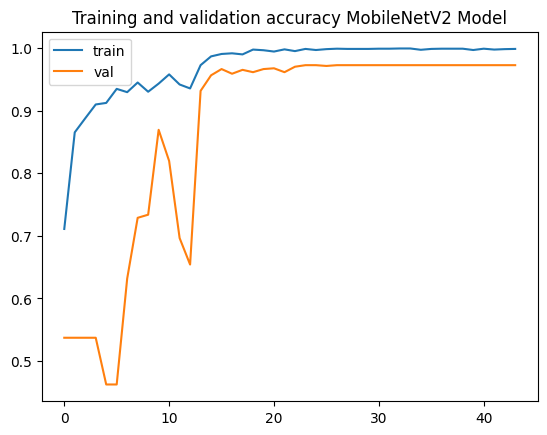

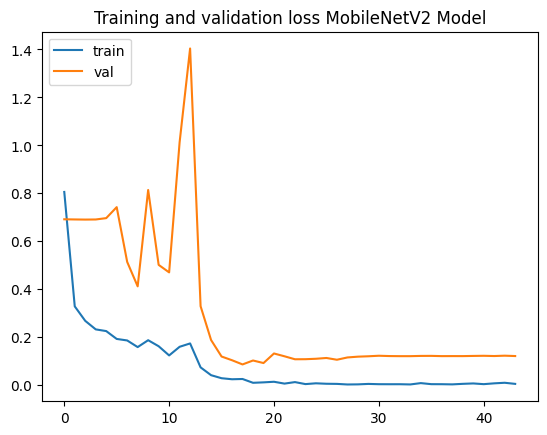

In [78]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model')
plt.legend(['train', 'val'], loc='upper left')

In [79]:
# Evaluate the model
test_loss, test_acc = MobileNetV2_model.evaluate(test_data, test_labels, verbose=2)
# Print out the model accuracy
print("Test accuracy:", test_acc)
# Print out the model loss
print("Test loss:", test_loss)

26/26 - 2s - loss: 0.1083 - accuracy: 0.9726 - 2s/epoch - 89ms/step
Test accuracy: 0.9726368188858032
Test loss: 0.1082841008901596


# Modelling DenseNet 121

In [80]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="DenseNet121.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [81]:
# Define Model
DenseNet121_model = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights=None,input_shape=train_data.shape[1:]),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(1, activation='sigmoid') 
  ])


# Compile Model
DenseNet121_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet121_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 47, 1024)       7031232   
                                                                 
 global_max_pooling2d_2 (Glo  (None, 1024)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_24 (Dense)            (None, 256)               262400    
                                                                 
 dense_25 (Dense)            (None, 1)                 257       
                                                                 
Total params: 7,293,889
Trainable params: 7,210,241
Non-trainable params: 83,648
______________________________________

In [82]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet121_model = DenseNet121_model.fit(train_data, train_labels, validation_data=(test_data, test_labels), batch_size=batch_size, epochs=num_epochs, callbacks=callbacks)

Epoch 1/100
713/713 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.7363
Epoch 1: val_accuracy improved from -inf to 0.81095, saving model to DenseNet121.h5
713/713 [==============================] - 127s 82ms/step - loss: 0.6564 - accuracy: 0.7363 - val_loss: 0.4655 - val_accuracy: 0.8109 - lr: 0.0010
Epoch 2/100
713/713 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8808
Epoch 2: val_accuracy improved from 0.81095 to 0.97264, saving model to DenseNet121.h5
713/713 [==============================] - 57s 80ms/step - loss: 0.2850 - accuracy: 0.8808 - val_loss: 0.0878 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 3/100
713/713 [==============================] - ETA: 0s - loss: 0.1659 - accuracy: 0.9369
Epoch 3: val_accuracy did not improve from 0.97264
713/713 [==============================] - 55s 77ms/step - loss: 0.1659 - accuracy: 0.9369 - val_loss: 0.1188 - val_accuracy: 0.9552 - lr: 0.0010
Epoch 4/100
713/713 [===========================

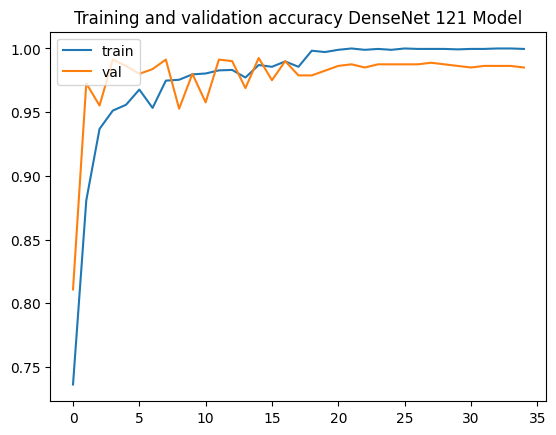

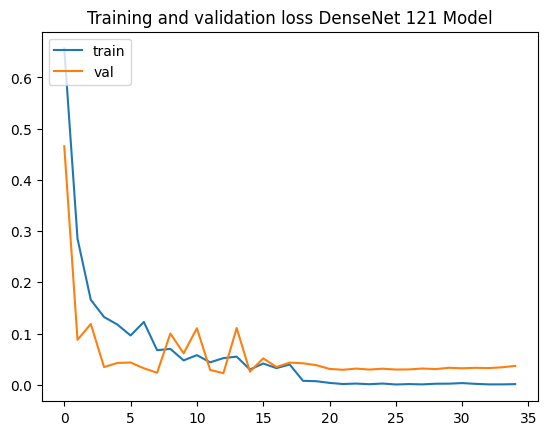

In [83]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet121_model.history['accuracy' ]
val_acc  = history_DenseNet121_model.history['val_accuracy' ]
loss     = history_DenseNet121_model.history['loss' ]
val_loss = history_DenseNet121_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet 121 Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet 121 Model')
plt.legend(['train', 'val'], loc='upper left')

In [85]:
# Evaluate the model
test_loss, test_acc = DenseNet121_model.evaluate(test_data, test_labels, verbose=2)
# Print out the model accuracy
print("Test accuracy:", test_acc)
# Print out the model loss
print("Test loss:", test_loss)

26/26 - 5s - loss: 0.0257 - accuracy: 0.9925 - 5s/epoch - 181ms/step
Test accuracy: 0.9925373196601868
Test loss: 0.025736529380083084


# Modelling Xception

In [86]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Xception.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [87]:
# Define Model
Xception_model = tf.keras.models.Sequential([
    # Xception Layer
    Xception(include_top=False,weights=None,input_shape=train_data.shape[1:]),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(1, activation='sigmoid') 
  ])


# Compile Model
Xception_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 47, 2048)       20860904  
                                                                 
 global_max_pooling2d_3 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_13 (Dropout)        (None, 2048)              0         
                                                                 
 dense_26 (Dense)            (None, 256)               524544    
                                                                 
 dense_27 (Dense)            (None, 1)                 257       
                                                                 
Total params: 21,385,705
Trainable params: 21,331,177
Non-trainable params: 54,528
____________________________________

In [88]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model = Xception_model.fit(train_data, train_labels, validation_data=(test_data, test_labels), batch_size=batch_size, epochs=num_epochs, callbacks=callbacks)

Epoch 1/100
713/713 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.7402
Epoch 1: val_accuracy improved from -inf to 0.73632, saving model to Xception.h5
713/713 [==============================] - 75s 64ms/step - loss: 0.5908 - accuracy: 0.7402 - val_loss: 0.4620 - val_accuracy: 0.7363 - lr: 0.0010
Epoch 2/100
713/713 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.8885
Epoch 2: val_accuracy did not improve from 0.73632
713/713 [==============================] - 44s 61ms/step - loss: 0.2874 - accuracy: 0.8885 - val_loss: 0.6911 - val_accuracy: 0.6692 - lr: 0.0010
Epoch 3/100
713/713 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 0.9344
Epoch 3: val_accuracy improved from 0.73632 to 0.98259, saving model to Xception.h5
713/713 [==============================] - 44s 62ms/step - loss: 0.1808 - accuracy: 0.9344 - val_loss: 0.0654 - val_accuracy: 0.9826 - lr: 0.0010
Epoch 4/100
713/713 [==============================] - 

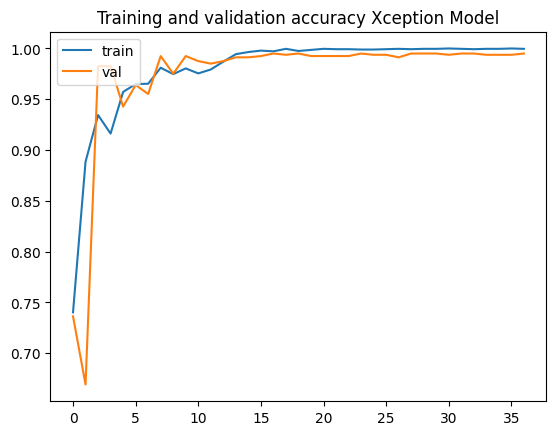

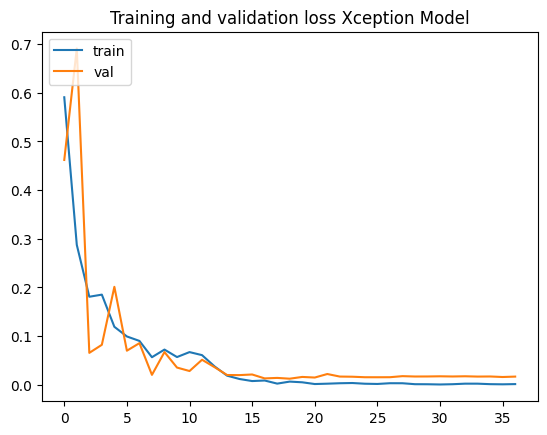

In [89]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model.history['accuracy' ]
val_acc  = history_Xception_model.history['val_accuracy' ]
loss     = history_Xception_model.history['loss' ]
val_loss = history_Xception_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy Xception Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss Xception Model')
plt.legend(['train', 'val'], loc='upper left')

In [92]:
# Evaluate the model
test_loss, test_acc = Xception_model.evaluate(test_data, test_labels, verbose=2)
# Print out the model accuracy
print("Test accuracy:", test_acc)
# Print out the model loss
print("Test loss:", test_loss)

26/26 - 4s - loss: 0.0129 - accuracy: 0.9950 - 4s/epoch - 140ms/step
Test accuracy: 0.9950248599052429
Test loss: 0.012920591980218887


# Modelling EfficientNetV2S

In [93]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="EfficientNetV2S.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [94]:
# Define Model
EfficientNetV2S_model = tf.keras.models.Sequential([
    # EfficientNetV2S Layer
    EfficientNetV2S(include_top=False,weights=None,input_shape=train_data.shape[1:]),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(1, activation='sigmoid') 
  ])


# Compile Model
EfficientNetV2S_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
EfficientNetV2S_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 4, 47, 1280)      20330928  
 l)                                                              
                                                                 
 global_max_pooling2d_4 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_14 (Dropout)        (None, 1280)              0         
                                                                 
 dense_28 (Dense)            (None, 256)               327936    
                                                                 
 dense_29 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,659,121
Trainable params: 20,505,249

In [95]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_EfficientNetV2S_model = EfficientNetV2S_model.fit(train_data, train_labels, validation_data=(test_data, test_labels), batch_size=batch_size, epochs=num_epochs, callbacks=callbacks)

Epoch 1/100
713/713 [==============================] - ETA: 0s - loss: 0.9647 - accuracy: 0.5898
Epoch 1: val_accuracy improved from -inf to 0.53731, saving model to EfficientNetV2S.h5
713/713 [==============================] - 158s 106ms/step - loss: 0.9647 - accuracy: 0.5898 - val_loss: 0.7088 - val_accuracy: 0.5373 - lr: 0.0010
Epoch 2/100
713/713 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5936
Epoch 2: val_accuracy improved from 0.53731 to 0.54851, saving model to EfficientNetV2S.h5
713/713 [==============================] - 73s 102ms/step - loss: 0.6884 - accuracy: 0.5936 - val_loss: 0.7365 - val_accuracy: 0.5485 - lr: 0.0010
Epoch 3/100
713/713 [==============================] - ETA: 0s - loss: 0.6377 - accuracy: 0.6518
Epoch 3: val_accuracy improved from 0.54851 to 0.56219, saving model to EfficientNetV2S.h5
713/713 [==============================] - 72s 102ms/step - loss: 0.6377 - accuracy: 0.6518 - val_loss: 0.7024 - val_accuracy: 0.5622 - lr: 0.00

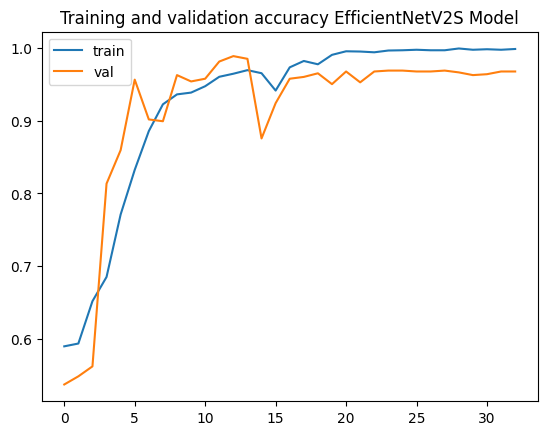

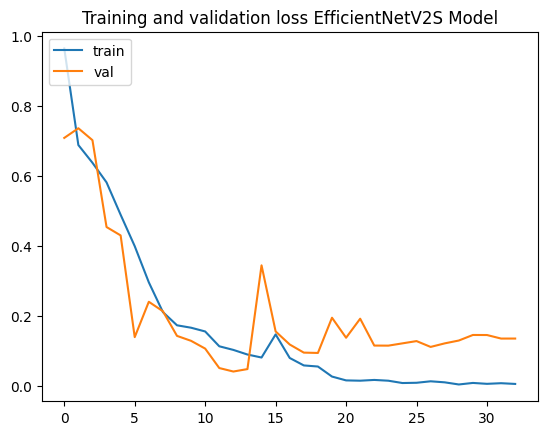

In [96]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_EfficientNetV2S_model.history['accuracy' ]
val_acc  = history_EfficientNetV2S_model.history['val_accuracy' ]
loss     = history_EfficientNetV2S_model.history['loss' ]
val_loss = history_EfficientNetV2S_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy EfficientNetV2S Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss EfficientNetV2S Model')
plt.legend(['train', 'val'], loc='upper left')

In [97]:
# Evaluate the model
test_loss, test_acc = EfficientNetV2S_model.evaluate(test_data, test_labels, verbose=2)
# Print out the model accuracy
print("Test accuracy:", test_acc)
# Print out the model loss
print("Test loss:", test_loss)

26/26 - 7s - loss: 0.0405 - accuracy: 0.9888 - 7s/epoch - 257ms/step
Test accuracy: 0.9888059496879578
Test loss: 0.040531225502491


# Model Evaluation

## DIY Evaluation

In [98]:
# evaluate model
print("==========================Evaluate Model====================")
scores_DIY = DIY_Model.evaluate(test_data, test_labels, verbose=1)
print("Accuracy: %.6f%%" % (scores_DIY[1]*100))
print("Loss: %.6f%%" % (scores_DIY[0]*100))

==========================Evaluate Model====================
26/26 [==============================] - 1s 26ms/step - loss: 0.1645 - accuracy: 0.9527
Accuracy: 95.273632%
Loss: 16.454378%


26/26 [==============================] - 1s 21ms/step
==========================Confusion Matrix====================


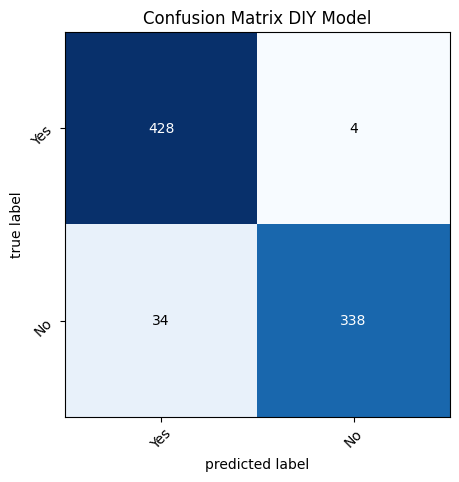

==========================Classification Report====================
Classification Report:
              precision    recall  f1-score   support

         Yes       0.93      0.99      0.96       432
          No       0.99      0.91      0.95       372

    accuracy                           0.95       804
   macro avg       0.96      0.95      0.95       804
weighted avg       0.96      0.95      0.95       804

F1 Score: 0.952536398712545


In [107]:
# Confusion Matrix and Classification Report
classes = ['Yes', 'No']

# Calculate predictions
y_pred = DIY_Model.predict(test_data)
predicted_labels = np.where(y_pred > 0.5, 1, 0).astype(int)
predicted_classes = [classes[label] for label in predicted_labels.flatten()]

# Calculate confusion matrix
print("==========================Confusion Matrix====================")
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(5, 5))
ax.set_xticklabels([''] + classes, rotation=45)
ax.set_yticklabels([''] + classes, rotation=45)
plt.title ('Confusion Matrix DIY Model')
plt.show()

# Print classification report
print("==========================Classification Report====================")
report = classification_report(test_labels, predicted_labels, target_names=classes)
print("Classification Report:")
print(report)

# Calculate F1 score
f1_DIY = f1_score(test_labels, predicted_labels, average='weighted')
print("F1 Score:", f1_DIY)

## MobileNet V2 Evaluation

In [108]:
# evaluate model
print("==========================Evaluate Model====================")
scores_MobileNetV2 = MobileNetV2_model.evaluate(test_data, test_labels, verbose=1)
print("Accuracy: %.6f%%" % (scores_MobileNetV2[1]*100))
print("Loss: %.6f%%" % (scores_DIY[0]*100))

==========================Evaluate Model====================
26/26 [==============================] - 1s 53ms/step - loss: 0.1083 - accuracy: 0.9726
Accuracy: 97.263682%
Loss: 16.454378%


26/26 [==============================] - 2s 48ms/step
==========================Confusion Matrix====================


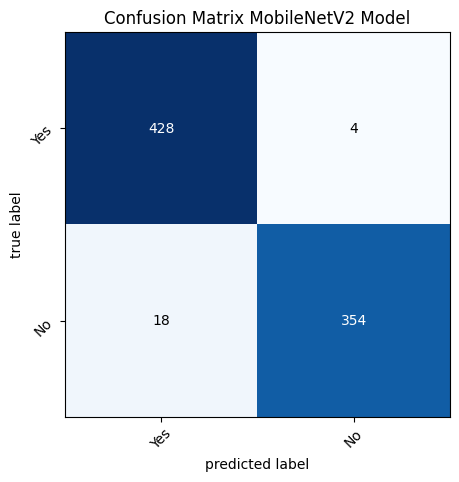

==========================Classification Report====================
Classification Report:
              precision    recall  f1-score   support

         Yes       0.96      0.99      0.97       432
          No       0.99      0.95      0.97       372

    accuracy                           0.97       804
   macro avg       0.97      0.97      0.97       804
weighted avg       0.97      0.97      0.97       804

F1 Score: 0.9725925867277959


In [109]:
# Confusion Matrix and Classification Report
classes = ['Yes', 'No']

# Calculate predictions
y_pred = MobileNetV2_model.predict(test_data)
predicted_labels = np.where(y_pred > 0.5, 1, 0).astype(int)
predicted_classes = [classes[label] for label in predicted_labels.flatten()]

# Calculate confusion matrix
print("==========================Confusion Matrix====================")
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(5, 5))
ax.set_xticklabels([''] + classes, rotation=45)
ax.set_yticklabels([''] + classes, rotation=45)
plt.title ('Confusion Matrix MobileNetV2 Model')
plt.show()

# Print classification report
print("==========================Classification Report====================")
report = classification_report(test_labels, predicted_labels, target_names=classes)
print("Classification Report:")
print(report)

# Calculate F1 score
f1_MobileNetV2 = f1_score(test_labels, predicted_labels, average='weighted')
print("F1 Score:", f1_MobileNetV2)

## DenseNet 121 Evaluation

In [110]:
# evaluate model
print("==========================Evaluate Model====================")
scores_DenseNet121 = DenseNet121_model.evaluate(test_data, test_labels, verbose=1)
print("Accuracy: %.6f%%" % (scores_DenseNet121[1]*100))
print("Loss: %.6f%%" % (scores_DIY[0]*100))

==========================Evaluate Model====================
26/26 [==============================] - 3s 101ms/step - loss: 0.0257 - accuracy: 0.9925
Accuracy: 99.253732%
Loss: 16.454378%


26/26 [==============================] - 4s 94ms/step
==========================Confusion Matrix====================


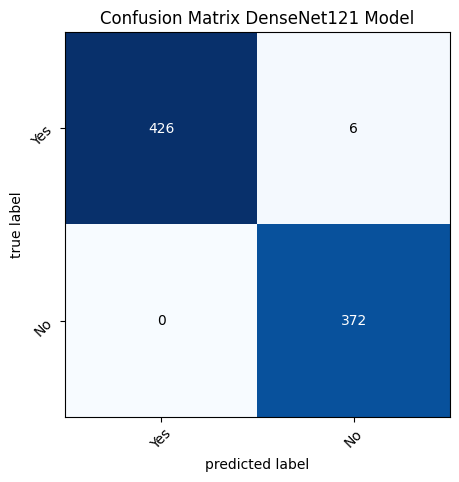

==========================Classification Report====================
Classification Report:
              precision    recall  f1-score   support

         Yes       1.00      0.99      0.99       432
          No       0.98      1.00      0.99       372

    accuracy                           0.99       804
   macro avg       0.99      0.99      0.99       804
weighted avg       0.99      0.99      0.99       804

F1 Score: 0.992541070869429


In [111]:
# Confusion Matrix and Classification Report
classes = ['Yes', 'No']

# Calculate predictions
y_pred = DenseNet121_model.predict(test_data)
predicted_labels = np.where(y_pred > 0.5, 1, 0).astype(int)
predicted_classes = [classes[label] for label in predicted_labels.flatten()]

# Calculate confusion matrix
print("==========================Confusion Matrix====================")
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(5, 5))
ax.set_xticklabels([''] + classes, rotation=45)
ax.set_yticklabels([''] + classes, rotation=45)
plt.title ('Confusion Matrix DenseNet121 Model')
plt.show()

# Print classification report
print("==========================Classification Report====================")
report = classification_report(test_labels, predicted_labels, target_names=classes)
print("Classification Report:")
print(report)

# Calculate F1 score
f1_DenseNet121 = f1_score(test_labels, predicted_labels, average='weighted')
print("F1 Score:", f1_DenseNet121)

## Xception Evaluation

In [112]:
# evaluate model
print("==========================Evaluate Model====================")
scores_Xception = Xception_model.evaluate(test_data, test_labels, verbose=1)
print("Accuracy: %.6f%%" % (scores_Xception[1]*100))
print("Loss: %.6f%%" % (scores_DIY[0]*100))

==========================Evaluate Model====================
26/26 [==============================] - 2s 90ms/step - loss: 0.0129 - accuracy: 0.9950
Accuracy: 99.502486%
Loss: 16.454378%


26/26 [==============================] - 3s 86ms/step
==========================Confusion Matrix====================


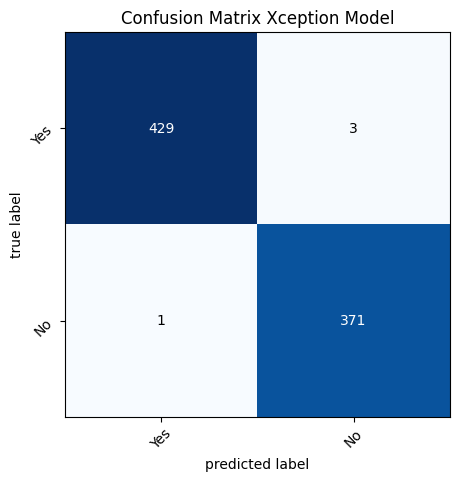

==========================Classification Report====================
Classification Report:
              precision    recall  f1-score   support

         Yes       1.00      0.99      1.00       432
          No       0.99      1.00      0.99       372

    accuracy                           1.00       804
   macro avg       0.99      1.00      0.99       804
weighted avg       1.00      1.00      1.00       804

F1 Score: 0.9950257730834143


In [113]:
# Confusion Matrix and Classification Report
classes = ['Yes', 'No']

# Calculate predictions
y_pred = Xception_model.predict(test_data)
predicted_labels = np.where(y_pred > 0.5, 1, 0).astype(int)
predicted_classes = [classes[label] for label in predicted_labels.flatten()]

# Calculate confusion matrix
print("==========================Confusion Matrix====================")
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(5, 5))
ax.set_xticklabels([''] + classes, rotation=45)
ax.set_yticklabels([''] + classes, rotation=45)
plt.title ('Confusion Matrix Xception Model')
plt.show()

# Print classification report
print("==========================Classification Report====================")
report = classification_report(test_labels, predicted_labels, target_names=classes)
print("Classification Report:")
print(report)

# Calculate F1 score
f1_Xception = f1_score(test_labels, predicted_labels, average='weighted')
print("F1 Score:", f1_Xception)

## EfficientNetV2S

In [114]:
# evaluate model
print("==========================Evaluate Model====================")
scores_EfficientNetV2S = EfficientNetV2S_model.evaluate(test_data, test_labels, verbose=1)
print("Accuracy: %.6f%%" % (scores_EfficientNetV2S[1]*100))
print("Loss: %.6f%%" % (scores_DIY[0]*100))

==========================Evaluate Model====================
26/26 [==============================] - 3s 130ms/step - loss: 0.0405 - accuracy: 0.9888
Accuracy: 98.880595%
Loss: 16.454378%


26/26 [==============================] - 6s 124ms/step
==========================Confusion Matrix====================


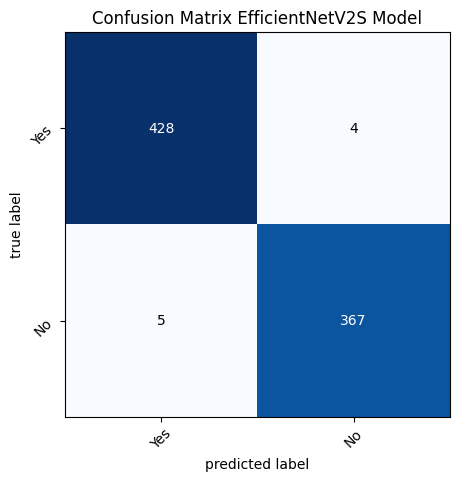

==========================Classification Report====================
Classification Report:
              precision    recall  f1-score   support

         Yes       0.99      0.99      0.99       432
          No       0.99      0.99      0.99       372

    accuracy                           0.99       804
   macro avg       0.99      0.99      0.99       804
weighted avg       0.99      0.99      0.99       804

F1 Score: 0.9888049076922237


In [115]:
# Confusion Matrix and Classification Report
classes = ['Yes', 'No']

# Calculate predictions
y_pred = EfficientNetV2S_model.predict(test_data)
predicted_labels = np.where(y_pred > 0.5, 1, 0).astype(int)
predicted_classes = [classes[label] for label in predicted_labels.flatten()]

# Calculate confusion matrix
print("==========================Confusion Matrix====================")
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(5, 5))
ax.set_xticklabels([''] + classes, rotation=45)
ax.set_yticklabels([''] + classes, rotation=45)
plt.title ('Confusion Matrix EfficientNetV2S Model')
plt.show()

# Print classification report
print("==========================Classification Report====================")
report = classification_report(test_labels, predicted_labels, target_names=classes)
print("Classification Report:")
print(report)

# Calculate F1 score
f1_EfficientNetV2S = f1_score(test_labels, predicted_labels, average='weighted')
print("F1 Score:", f1_EfficientNetV2S)

# Comparison

In [118]:
# Make dictionary of all models
models = {
    "DIY Arc Model": DIY_Model,
    "MobileNet V2": MobileNetV2_model,
    "DenseNet 121": DenseNet121_model,
    "Xception": Xception_model,
    "EfficientNetV2S":EfficientNetV2S_model
}

Accuracy ={
    "DIY Arc Model": scores_DIY[1],
    "MobileNet V2": scores_MobileNetV2[1],
    "DenseNet 121": scores_DenseNet121[1],
    "Xception": scores_Xception[1],
    "EfficientNetV2S":scores_EfficientNetV2S[1]
}

Loss = {
    "DIY Arc Model": scores_DIY[0],
    "MobileNet V2": scores_MobileNetV2[0],
    "DenseNet 121": scores_DenseNet121[0],
    "Xception": scores_Xception[0],
    "EfficientNetV2S":scores_EfficientNetV2S[0]
}

f1 = {
    "DIY Arc Model": f1_DIY,
    "MobileNet V2": f1_MobileNetV2,
    "DenseNet 121": f1_DenseNet121,
    "Xception": f1_Xception,
    "EfficientNetV2S":f1_EfficientNetV2S
}

# Make dataframe of all models, accuracy, loss, and f1 score
df = pd.DataFrame(list(zip(models.keys(), Accuracy.values(), Loss.values(), f1.values())), columns =['Model', 'Accuracy', 'Loss', 'F1'])

# Sort dataframe by accuracy
df = df.sort_values(by=['Accuracy'], ascending=False)

# Print dataframe
print(df)

             Model  Accuracy      Loss        F1
3         Xception  0.995025  0.012921  0.995026
2     DenseNet 121  0.992537  0.025737  0.992541
4  EfficientNetV2S  0.988806  0.040531  0.988805
1     MobileNet V2  0.972637  0.108284  0.972593
0    DIY Arc Model  0.952736  0.164544  0.952536


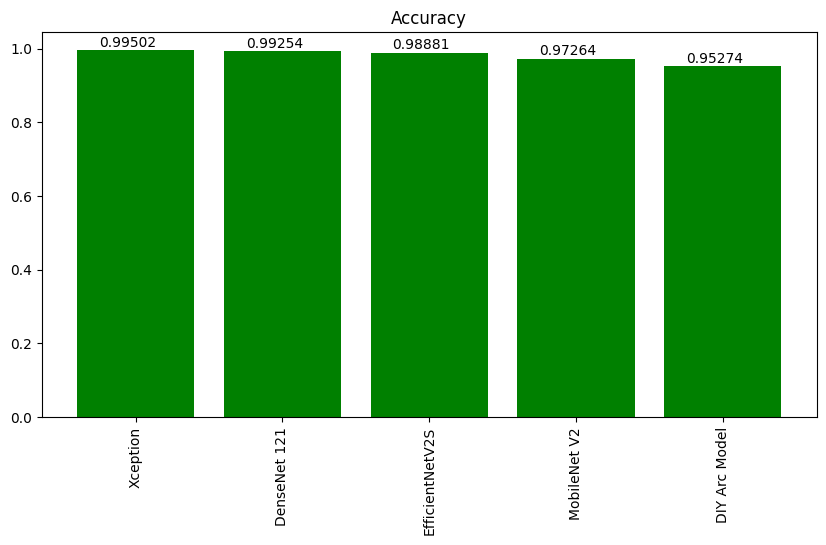

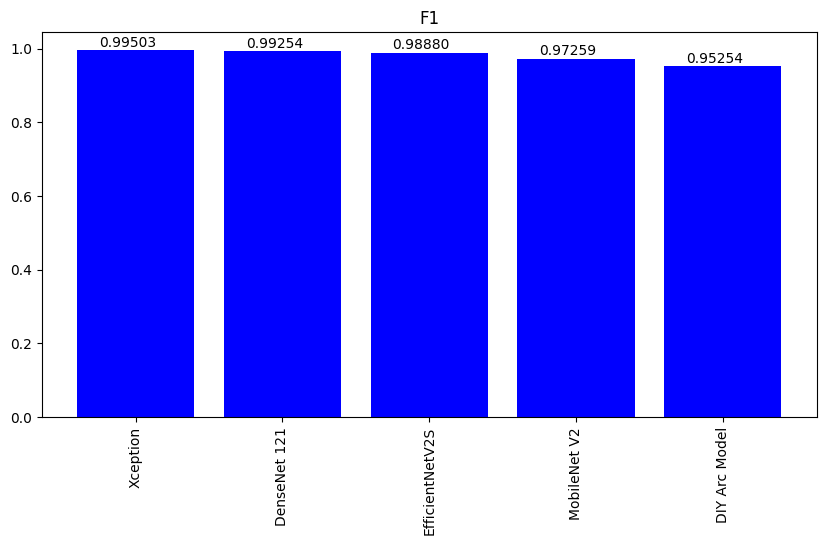

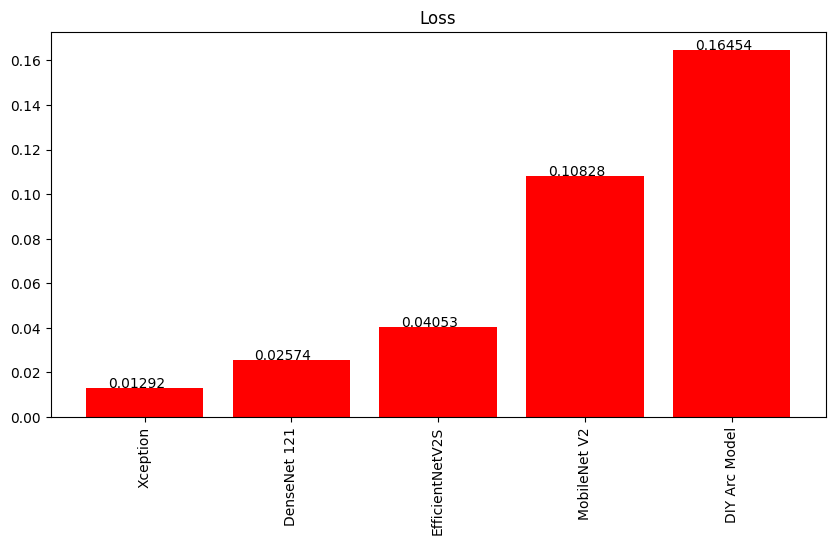

In [120]:
# make multiple plots for accuracy, f1 and loss with annotations
# Accuracy
plt.figure(figsize=(10, 5))
plt.title('Accuracy')
plt.bar(df['Model'], df['Accuracy'], color='green')
plt.xticks(rotation=90)
for i, v in enumerate(df['Accuracy']):
    plt.text(i - 0.25, v + 0.01, '{0:.5f}'.format(v))
plt.show()

# F1
plt.figure(figsize=(10, 5))
plt.title('F1')
plt.bar(df['Model'], df['F1'], color='blue')
plt.xticks(rotation=90)
for i, v in enumerate(df['F1']):
    plt.text(i - 0.25, v + 0.01, '{0:.5f}'.format(v))
plt.show()

# Loss
plt.figure(figsize=(10, 5))
plt.title('Loss')
plt.bar(df['Model'], df['Loss'], color='red')
plt.xticks(rotation=90)
for i, v in enumerate(df['Loss']):
    plt.text(i - 0.25, v + 0.0001, '{0:.5f}'.format(v))
plt.show()

# Save Model

In [122]:
# Save All Model
DIY_Model.save("DIY_model.h5")
MobileNetV2_model.save("MobileNetV2_model.h5")
DenseNet121_model.save("DenseNet121_model.h5")
Xception_model.save("Xception_model.h5")
EfficientNetV2S_model.save("EfficientNetV2S_model.h5")